In [1]:
import os
from datetime import date, timedelta
import xlrd
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import pycountry
import imageio
import glob

In [2]:
register_matplotlib_converters()

In [3]:
yesterday = date.today() - timedelta(days=1)
d = yesterday.strftime("%d")
m = yesterday.strftime("%m")
y = yesterday.strftime("%y")

In [4]:
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/'
exFile = 'COVID-19-geographic-disbtribution-worldwide-20' + y + '-' + m + '-'+ d +'.xlsx'
download = 'wget ' + url + exFile

In [5]:
os.system(download)

0

In [6]:
excel_data_df = pd.read_excel(exFile, sheet_name = 'COVID-19-geographic-disbtributi', index_col = [0,6], converters={'DateRep':pd.to_datetime, 'Cases':int, 'Deaths':int})

In [7]:
excel_data_df.drop(['Day', 'Month', 'Year', 'GeoId'], axis=1, inplace = True)

In [8]:
excel_data_df.head()

Cases  Deaths
DateRep    Countries and territories               
2020-03-21 Afghanistan                    2       0
2020-03-20 Afghanistan                    0       0
2020-03-19 Afghanistan                    0       0
2020-03-18 Afghanistan                    1       0
2020-03-17 Afghanistan                    5       0

Fill empty values:

In [9]:
excel_data_df.replace("", 0 , inplace=True)

In [10]:
new_index = pd.MultiIndex.from_product(excel_data_df.index.levels)
excel_data_df = excel_data_df.reindex(new_index)
excel_data_df.fillna(0, inplace = True)
excel_data_df = excel_data_df.reset_index().rename(columns={'level_0':'DateRep', 'level_1': 'Countries and territories'})

In [11]:
excel_data_df.head()

DateRep Countries and territories  Cases  Deaths
0 2019-12-31               Afghanistan    0.0     0.0
1 2019-12-31                   Albania    0.0     0.0
2 2019-12-31                   Algeria    0.0     0.0
3 2019-12-31                   Andorra    0.0     0.0
4 2019-12-31       Antigua_and_Barbuda    0.0     0.0

Set correct ISO:

In [12]:
def find_ISO(country_name):
    
    if country_name == 'United_States_of_America':
        return 'USA'
    if country_name == 'Czech_Republic':
        return 'CZE'
    if country_name == 'Iran':
        return 'IRN'
    if country_name == 'Russia':
        return 'RUS'
    if country_name == 'Indonesia':
        return 'IDN'
    if country_name == 'South_Korea':
        return 'KOR'
    if country_name == 'Taiwan':
        return 'TWN'
    if country_name == 'Vietnam':
        return 'VNM'
    if country_name == 'Bolivia':
        return 'BOL'
    if country_name == 'Saudi_Arabia':
        return 'SAU'
    if country_name == 'United_Arab_Emirates':
        return 'UAE'
    if country_name == 'United_Kingdom':
        return 'GBR'
    if country_name == 'Democratic_Republic_of_the_Congo':
        return 'COG'
    if country_name == 'New_Zealand':
        return 'NZL'
    if country_name == 'Venezuela':
        return 'VEN'
    if country_name == 'South_Africa':
        return 'ZAF'
    if country_name == 'CANADA':
        return 'CAD' 
    if country_name == 'Bosnia_and_Herzegovina':
        return 'BIH'
    if country_name == 'Burkina_Faso':
        return 'BFA'
    if country_name == 'Brunei_Darussalam':
        return 'BRN'
    if country_name == 'Cape_Verde':
        return 'CPV'
    if country_name == 'Cote_dIvoire':
        return 'CIV'
    if country_name == 'Dominican_Republic':
        return 'DOM'
    if country_name == 'Equatorial_Guinea':
        return 'GNQ'
    if country_name == 'El_Salvador':
        return 'SLV'
    if country_name == 'Sri_Lanka':
        return 'LKA'
    if country_name == 'Trinidad_and_Tobago':
        return 'TTO'
    if country_name == 'North_Macedonia':
        return 'MKD'
    if country_name == 'San_Marino':
        return 'SMR'
    if country_name == 'Central_African_Republic':
        return 'CAF'
    if country_name == 'Costa_Rica':
        return 'CRI'
    if country_name == 'Papua_New_Guinea':
        return 'PNG'
    if country_name == 'United_Republic_of_Tanzania':
        return 'TZA'
    if country_name == 'Moldova':
        return 'MDA'
    if country_name == 'Holy_See':
        return 'VAT'
    if country_name == 'Cayman_Islands':
        return 'CYM'
    if country_name == 'Palestine':
        return 'PSE'
    
 
    
    
    try:
        return pycountry.countries.get(name = country_name).alpha_3
    except AttributeError:
        return np.nan

In [13]:
excel_data_df['ISOid'] = excel_data_df.apply(lambda row: find_ISO(row['Countries and territories']), axis=1)

In [14]:
excel_data_df.head()

DateRep Countries and territories  Cases  Deaths ISOid
0 2019-12-31               Afghanistan    0.0     0.0   AFG
1 2019-12-31                   Albania    0.0     0.0   ALB
2 2019-12-31                   Algeria    0.0     0.0   DZA
3 2019-12-31                   Andorra    0.0     0.0   AND
4 2019-12-31       Antigua_and_Barbuda    0.0     0.0   NaN

In [15]:
excel_data_df['CumulativeCases']    = excel_data_df.sort_values(by='DateRep', ascending=True).groupby(['Countries and territories'])['Cases'].cumsum()
excel_data_df['CumulativeNewDeaths'] = excel_data_df.sort_values(by='DateRep', ascending=True).groupby(['Countries and territories'])['Deaths'].cumsum()

# New daily cases

In [16]:
yesterday_date = (date.today() - timedelta(days = 1)).strftime("%Y-%m-%d")
yesterday_df = excel_data_df[excel_data_df["DateRep"] == yesterday_date].copy()
yesterday_df['ISOid'] = yesterday_df.apply(lambda row: find_ISO(row['Countries and territories']), axis=1)

In [17]:
yesterday_df.head()

DateRep Countries and territories  Cases  Deaths ISOid  \
14256 2020-03-21               Afghanistan    2.0     0.0   AFG   
14257 2020-03-21                   Albania    0.0     0.0   ALB   
14258 2020-03-21                   Algeria   12.0     3.0   DZA   
14259 2020-03-21                   Andorra    0.0     0.0   AND   
14260 2020-03-21       Antigua_and_Barbuda    0.0     0.0   NaN   

       CumulativeCases  CumulativeNewDeaths  
14256             24.0                  0.0  
14257             70.0                  2.0  
14258             94.0                 10.0  
14259             75.0                  0.0  
14260              1.0                  0.0

In [18]:
fig = px.choropleth(yesterday_df, 
                    locations = "ISOid",
                    color = "Cases", 
                    hover_name = "Countries and territories", 
                    color_continuous_scale = px.colors.sequential.Plasma
                    )

fig.update_layout(
    title_text = "Yesterday (" + yesterday_date + ") confirmed new cases",
)

fig.show()
fig.write_image("NewConfCasesMap.pdf")

# Cumulative cases

In [19]:
days = pd.date_range("2020-01-01", 
                     (date.today() - timedelta(days = 1)).strftime("%Y-%m-%d"), 
                     freq = '1d')

for day in days:
    
    day_df = excel_data_df[excel_data_df["DateRep"] == day].copy()
    

    fig = px.choropleth(day_df, 
                    locations = "ISOid",
                    color = np.log10(day_df["CumulativeCases"]+1), #+1 for the log scale
                    range_color=(0, 5),
                    color_continuous_scale = px.colors.sequential.Oranges,
                    labels={'color':'Cases'}
                    )

    fig.update_layout(
        title_text = "Confirmed cumulative cases on " + day.strftime("%Y-%m-%d"),
        coloraxis_colorbar=dict(tickvals=[1, 3, 5],
                                ticktext = ["10", "1000", "100000"]),
        annotations = [dict(
        x=0.5,
        y=0.0,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide">European Centre for Disease Prevention and Control</a>',
        showarrow = False
    )],
        geo = dict(
        landcolor = px.colors.sequential.Oranges[0],
        )
    )

    fig.write_image("NewConfCasesEvolutionMap/CumulativeCasesMap" + day.strftime("%Y-%m-%d") + ".png")

In [20]:
filenames = glob.glob('NewConfCasesEvolutionMap/CumulativeCasesMap2020*-*.png')
filenames.sort()
images = []
for filename in filenames:
    images.append(imageio.imread(filename))

kargs = { 'duration': 0.3 }
imageio.mimsave('NewConfCasesEvolutionMap/CumulativeCasesMap2020.gif', images, **kargs)

# Global trends

In [51]:
#Nations = ['Italy', 'United_States_of_America']
Nations = ['Italy', 'China', 'United_States_of_America', 'United_Kingdom', 'France', 'Spain']

In [52]:
def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(k * (x - x0)))

In [57]:
def exp_func(x, a, b, x0, y0):
    return a * np.exp(b * (x - x0)) + y0

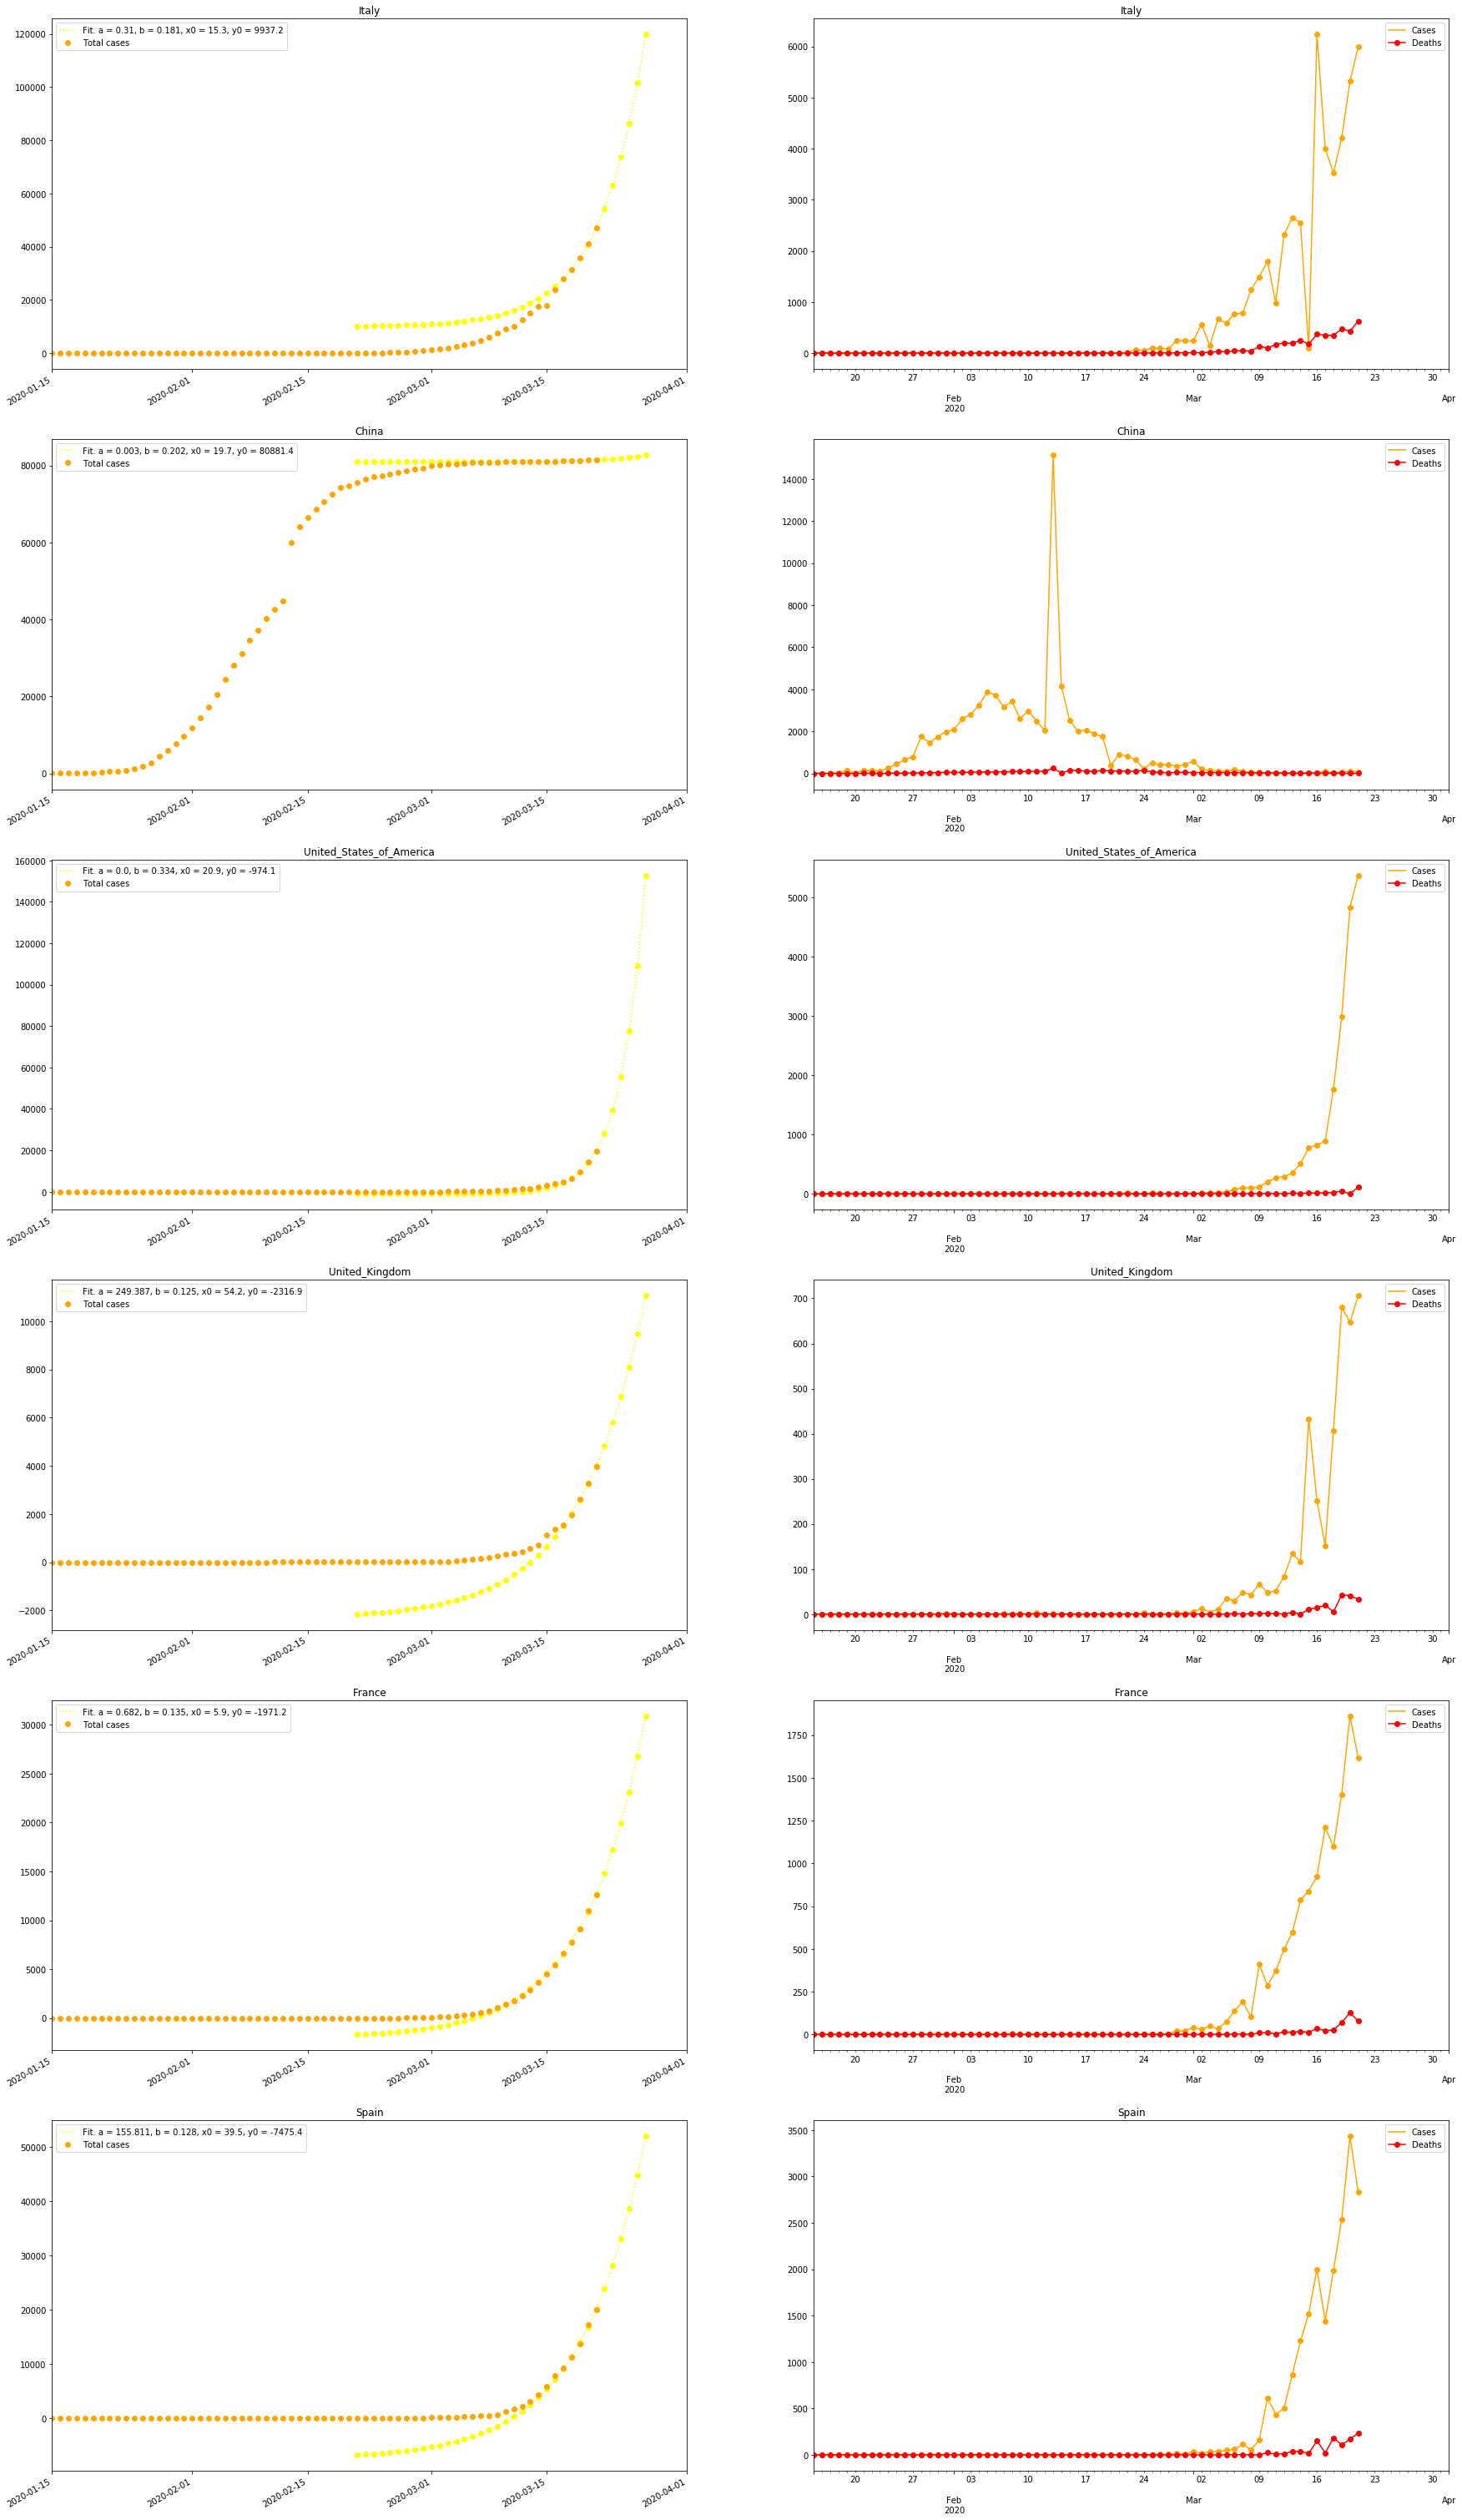

In [65]:
fig, axes = plt.subplots(len(Nations), 2, figsize=(30, 10*len(Nations)))
axes = axes.ravel()


i = 0
for n in Nations:
    
    df_n = excel_data_df[excel_data_df['Countries and territories'] == n].copy()
    
    #Calculate the fit in the last X days
    fit_start_day = 5
    
    #Show fit in this range: previous 30 days and future 5 days
    x_fit = pd.date_range((date.today() - timedelta(days = 30)).strftime("%Y-%m-%d"), 
                          (date.today() + timedelta(days = 5)).strftime("%Y-%m-%d"), 
                           freq = '1d')

    delta =  mdates.datestr2num('2020-01-01') #Rescale data from 1st of Jan to help the fit
    
    df_n.reset_index(inplace = True)
    df_n.sort_values(by='DateRep', ascending = False, inplace = True)
    
    #Run the sigmoid fit only if the peak of new cases was reached at least X days ago 
    if (df_n['Cases']).idxmax() > df_n['Cases'].first_valid_index() + 10:
        
        #Parameters starting guess
        L = max(df_n['CumulativeCases']) #Max cases
        k = 0.2 #Steepness of the curve
        x0 = 60 #Day of the turning point calculated from Jan 1
        
        par, pcov = curve_fit(logistic_func, 
                              mdates.date2num(df_n['DateRep'][:fit_start_day]) - delta,  
                              df_n['CumulativeCases'][:fit_start_day],
                              p0=(L, k, x0))
        L, k, x0 = par
        y_fit = logistic_func(mdates.date2num(x_fit), L, k, x0 + delta)
        axes[i].plot_date(x_fit, y_fit, linestyle = ":", c = 'yellow')
        axes[i].legend(['Fit. L = ' + str(round(L)) +  ', k = ' + str(round(k,3)) + ', x0 = ' + str(round(x0,1))])
    
    #Exponential fit
    else:
        
        #Parameters starting guess
        a = -1200
        b = 0.25
        x0 = 5 #Day of the turning point calculated from Jan 1
        y0 = 0
        
        par, pcov = curve_fit(exp_func, 
                              mdates.date2num(df_n['DateRep'][:fit_start_day]) - delta,  
                              df_n['CumulativeCases'][:fit_start_day],
                              p0=(a, b, x0, y0))
        a, b, x0, y0 = par
        y_fit = exp_func(mdates.date2num(x_fit), a, b, x0 + delta, y0)
        axes[i].plot_date(x_fit, y_fit, linestyle = ":", c = 'yellow')
        axes[i].legend(['Fit. a = ' + str(round(a, 3)) +  ', b = ' + str(round(b, 3)) + ', x0 = ' + str(round(x0,1)) + ', y0 = ' + str(round(y0,1))])
    
    #Plot data
    df_n.plot(x = 'DateRep', y = 'CumulativeCases', ax = axes[i], c = 'orange', marker = 'o', linestyle = "None", label = "Total cases")
    #df_n.plot(x = 'DateRep', y = 'CumulativeDeaths', ax = axes[i], c = 'red', marker = 'o', linestyle = "None", label = "Total deaths")
    
    #Plotting window
    plotting_window_date_start = '2020-01-15'
    plotting_window_date_end   = (date.today() + timedelta(days = 10)).strftime("%Y-%m-%d")
    
    #axes[i].set_yscale('log')
    axes[i].set_xlim(plotting_window_date_start, plotting_window_date_end)
    axes[i].set_title(n)
    axes[i].set_xlabel('')
    
    df_n.plot(x = 'DateRep', y = 'Cases', ax = axes[i+1], c = 'orange', marker = 'o')
    df_n.plot(x = 'DateRep', y = 'Deaths', ax = axes[i+1], c = 'red', marker = 'o')
    axes[i+1].set_xlim(plotting_window_date_start, plotting_window_date_end)
    axes[i+1].set_title(n)
    axes[i+1].set_xlabel('')
    
    i+=2
    
plt.savefig('Tracker.pdf')